# Titanic Competition Made Simple

# Importing library files

In [89]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
%matplotlib inline

# Loading the dataset
Dataset are in CSV format, we will use Pandas library to fetch the data CSV file and manipulate it.

In [90]:
# Below two commands are used to fetch data from CSV file.
train_dataset_raw = pd.read_csv('../input/train.csv')
test_dataset = pd.read_csv('../input/test.csv')

# We created a duplicate copy of train dataset to manipulate it. 
train_dataset = train_dataset_raw.copy(deep = True)

# Here the train and test dataset are stored in a list so that we dont have to manipulate both one by one
data_cleaner = [train_dataset, test_dataset]

# Displays the overall details about the train dataset.
train_dataset_raw.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [91]:
print(train_dataset.isnull().sum())
print ('-'*10)
print (test_dataset.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# Cleaning of Data
As you can see the above dataset has many null  values, we will modify the dataset to give meaningful dataset to our model.

In [92]:
# This loop will manipulate both train and test dataset.
for dataset in data_cleaner:    
    #complete missing age values with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

## Feature Engineering
Here we will try to make new features by analysing the existing features.
This will increase our model efficiency and performance.

In [93]:
###CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:    
        
    #creates a new column 'CabinBool' which replaces the null values with '0' and who has cabin with '1'.
    dataset['CabinBool'] = (dataset['Cabin'].notnull().astype('int'))
    
    #Discrete variables - creates a family size with no. of siblings , spouse , parents or children.
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    #This will store the title of each person from its 'Name'.
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


    #Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    #This will create a Fare Slab according to no. provided. In our case we want '4' Fare Slab.
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    
    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    #Same goes with here, we will have 6 Age categories.
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 6)

In [94]:
# Check our training data after transformation.
train_dataset.sample(10)
print(train_dataset['Title'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Capt              1
Jonkheer          1
Sir               1
Mme               1
Ms                1
Lady              1
Don               1
the Countess      1
Name: Title, dtype: int64


**This will make a group of those titles which are less than 10 as 'Misc' column.**

In [95]:
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (train_dataset['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
train_dataset['Title'] = train_dataset['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train_dataset['Title'].value_counts())
print("-"*10)
title_namest = (test_dataset['Title'].value_counts() < stat_min)
test_dataset['Title'] = test_dataset['Title'].apply(lambda x: 'Misc' if title_namest.loc[x] == True else x)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------


## Label Encoding
It is used to transform non-numerical labels to numerical labels (or nominal categorical variables). Numerical labels are always between 0 and n_classes-1. 

Below code will create two column 'AgeBin_Code' and 'FareBin_Code' and convert the bins( ex: AgeBin has {1-16},{16-24} ) to numeric value and label them according to the bins.

In [96]:
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
print(train_dataset.columns)
test_dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'CabinBool',
       'FamilySize', 'IsAlone', 'Title', 'FareBin', 'AgeBin', 'AgeBin_Code',
       'FareBin_Code'],
      dtype='object')


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'CabinBool', 'FamilySize',
       'IsAlone', 'Title', 'FareBin', 'AgeBin', 'AgeBin_Code', 'FareBin_Code'],
      dtype='object')

# Correlation between features
 **Non-graphical method** : This correlation matrix is to understand the strength between variables. Correlation varies between -1 and +1.

* -1: Perfect negative linear correlation

* +1: Perfect positive linear correlation

* 0: No correlation

Generally, if the correlation between the two independent variables are high (>= 0.8) then we drop one independent variable otherwise it may lead to **multi collinearity problem** as both of them contains almost the same information.

So do you think we should use both of them as one of them is redundant. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

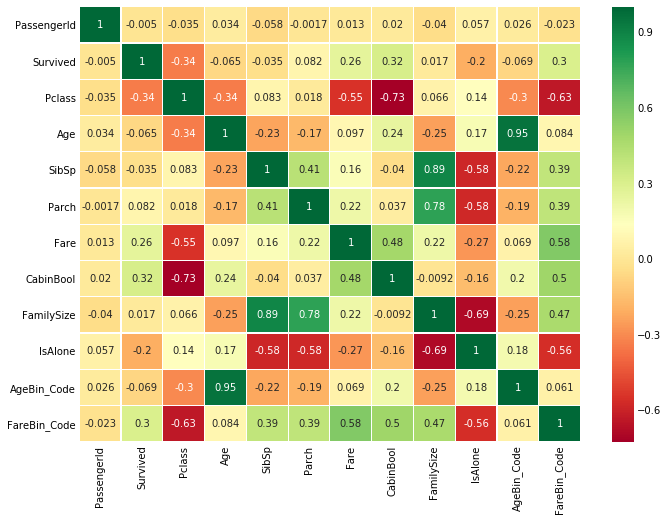

In [97]:
sns.heatmap(train_dataset.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

**Here we will select the features we want to include in our model.**

In [98]:
features_col=['Pclass','Sex','Embarked','IsAlone','Title','AgeBin_Code','FamilySize','FareBin_Code','CabinBool']
train_ds = train_dataset[features_col]
test_ds = test_dataset[features_col]
train_label = train_dataset['Survived']
print(train_ds.columns)
train_ds.head()

Index(['Pclass', 'Sex', 'Embarked', 'IsAlone', 'Title', 'AgeBin_Code',
       'FamilySize', 'FareBin_Code', 'CabinBool'],
      dtype='object')


,Pclass,Sex,Embarked,IsAlone,Title,AgeBin_Code,FamilySize,FareBin_Code,CabinBool
0,3,male,S,0,Mr,1,2,0,0
1,1,female,C,0,Mrs,2,2,3,1
2,3,female,S,1,Miss,1,1,1,0
3,1,female,S,0,Mrs,2,2,3,1
4,3,male,S,1,Mr,2,1,1,0


# One Hot Encoding
One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

Suppose we have Sex classes as 'male' and 'female'. One hot encoding will create two columns 'Sex_male' and 'Sex_female' and store the values as binary.

In [99]:
one_hot_encoded_training_predictors = pd.get_dummies(train_ds)
one_hot_encoded_testing_predictors = pd.get_dummies(test_ds)

**Check Correlation after One hot encoding.**

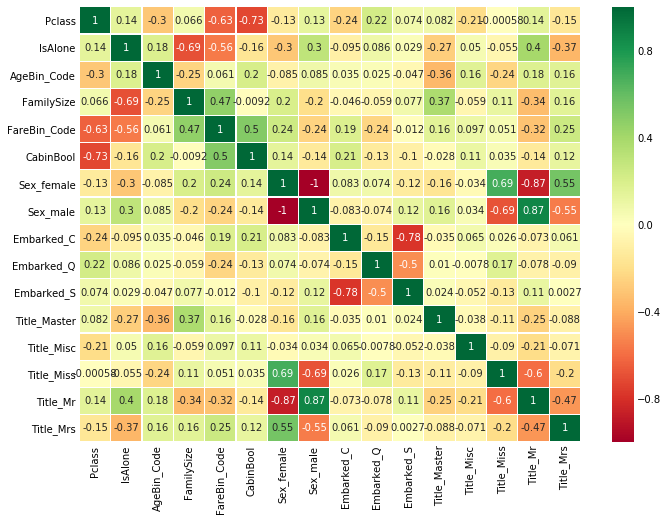

In [100]:
sns.heatmap(one_hot_encoded_training_predictors.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Most Correlating features are **(Sex_male,Title_Mr) , (Sex_female,Title_Miss)**
So , chances are they might have **redundant data**. Its better to remove one of the feature.

In [101]:
# Remove the correlated feature to reduce redundancy in model.
corln_col=['Title_Miss','Sex_male']
one_hot_encoded_training_predictors = one_hot_encoded_training_predictors.drop(corln_col,axis=1)
one_hot_encoded_testing_predictors = one_hot_encoded_testing_predictors.drop(corln_col,axis=1)

# Predictive Modeling
So now we will predict the whether the Passenger will survive or not using some great Classification Algorithms.Following are the algorithms I will use to make the model:

1. Logistic Regression

2. Support Vector Machines(Linear and radial)

3. K-Nearest Neighbours

4. Naive Bayes


In [102]:
# Import all the required packages.
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import svm #support vector Machine
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

# Cross Validation
Cross validation is a technique to limit the problem of overfitting. It assess how well the model will generalize to independent data set in the training phase.
Here we will be using two validation techniques :
1. **train_test_split**
2. **K-fold Cross Validation**

## train_test_split()
The data we use is usually split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s prediction on this subset.

The test_size=0.20 inside the function indicates the percentage of the data that should be held over for testing. It’s usually around 80/20 or 70/30.

In [103]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(one_hot_encoded_training_predictors, train_label, test_size=0.20)


## Radial Support Vector Machines(rbf-SVM)

In [104]:
svc_clf = SVC(kernel='rbf',C=1,gamma=0.1) #we can try different parameters
svc_clf.fit(train_X, train_y)
pred_svc = svc_clf.predict(test_X)
acc_svc = accuracy_score(test_y, pred_svc)

print(acc_svc)

0.8324022346368715


## Linear Support Vector Machines

In [105]:
linsvc_clf = LinearSVC()
linsvc_clf.fit(train_X, train_y)
pred_linsvc = linsvc_clf.predict(test_X)
acc_linsvc = accuracy_score(test_y, pred_linsvc)

print(acc_linsvc)

0.8324022346368715


## Logistic Regression

In [106]:
logreg_clf = LogisticRegression()
logreg_clf.fit(train_X, train_y)
pred_logreg = logreg_clf.predict(test_X)
acc_logreg = accuracy_score(test_y, pred_logreg)

print(acc_logreg)

0.8100558659217877


## K-Nearest Neighbours(KNN)

In [107]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_X, train_y)
pred_knn = knn_clf.predict(test_X)
acc_knn = accuracy_score(test_y, pred_knn)

print(acc_knn)


0.8156424581005587


## Gaussian Naive Bayes

In [108]:
gnb_clf = GaussianNB()
gnb_clf.fit(train_X, train_y)
pred_gnb = gnb_clf.predict(test_X)
acc_gnb = accuracy_score(test_y, pred_gnb)

print(acc_gnb)

0.776536312849162


**Comparing all model performance.**

In [109]:
#Compare all model performance.
model_performance = pd.DataFrame({
    'Model': ['Radial SVM', 'Linear SVM', 
              'Logistic Regression', 'K Nearest Neighbors', 'Gaussian Naive Bayes'],
    'Accuracy': [acc_svc, acc_linsvc, 
              acc_logreg, acc_knn, acc_gnb]
})

model_performance.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,Radial SVM,0.832402
1,Linear SVM,0.832402
3,K Nearest Neighbors,0.815642
2,Logistic Regression,0.810056
4,Gaussian Naive Bayes,0.776536


## K- fold Cross Validation

1.  The K-Fold Cross Validation works by first dividing the dataset into k-subsets.
2.   Let's say we divide the dataset into (k=5) parts. We reserve 1 part for testing and train the algorithm over the 4 parts.
3.   We continue the process by changing the testing part in each iteration and training the algorithm over the other parts. The accuracies and errors are then averaged to get a average accuracy of the algorithm.

This is called K-Fold Cross Validation.

In [110]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear',gamma='auto'),svm.SVC(kernel='rbf',gamma='auto'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model, train_X, train_y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.830047,0.045967
Radial Svm,0.832864,0.042873
Logistic Regression,0.829988,0.051466
KNN,0.818838,0.050027
Decision Tree,0.815943,0.043095
Naive Bayes,0.780869,0.055714
Random Forest,0.832864,0.045127


## Predict the testing dataset
Choose any model which gives you the best results

In [115]:
sub_clf = RandomForestClassifier(n_estimators=100)
sub_clf.fit(one_hot_encoded_training_predictors, train_label)
submission_predictions = sub_clf.predict(one_hot_encoded_testing_predictors)

## Submission
Submit the csv file in the specified format.

In [116]:
submission = pd.DataFrame({
        "PassengerId": test_dataset['PassengerId'],
        "Survived": submission_predictions
    })

submission.to_csv("titanic.csv", index=False)

**I hope this kernal may help you in any way. Please support me if this helps you by giving UPVOTE.**